# Data Exploration

Generation, capacity, and weather data is explored with to:
- Get a feel for the data
- Isolate magnitude and variability
- Understand different sources of variation (trends, seasonality, weather fluctuations)
- Get a sense for the kinds of features that would be helpful
- Determine the modeling techniques likely to be most effective
- Ascertain how best to structure the modeling (single model vs multiple, across operators or seasons)

## Setup

In [2]:
# Import packages
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


### Set display preferences
# Tabular
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)

# Plots
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 6]
sns.set(style='white')
sns.set_style("ticks")
sns.set_context("notebook", rc={"axes.titlesize":16,"axes.labelsize":15, "legend.fontsize":15})
plt.rcParams['figure.figsize'] = [15, 6]

# Warnings
import warnings; warnings.filterwarnings(action='ignore')

## Read in Data

In [3]:
datapath = pathlib.Path('data/processed_data')

In [4]:
actuals = pd.read_csv(datapath/'actuals.csv')
actuals_hourly = pd.read_csv(datapath/'actuals_hourly.csv')

capacity = pd.read_csv(datapath/'capacity.csv')

weather_hourly = pd.read_csv(datapath/'hourly_weather_hist.csv')
weather_daily = pd.read_csv(datapath/'daily_weather_hist.csv')

In [5]:
actuals.set_index(pd.DatetimeIndex(actuals['int_start']), drop=True, inplace=True)
actuals['solar'] = pd.to_numeric(actuals['solar'])

actuals_hourly.set_index(pd.DatetimeIndex(actuals_hourly['int_start']), drop=True, inplace=True)
actuals_hourly['solar'] = pd.to_numeric(actuals_hourly['solar'])
# actuals.head()

Data for 2018 goes up till early November - this should be kept in mind when making comparisons across years

In [6]:
actuals.index.max()

Timestamp('2018-11-03 08:00:00')

In [7]:
plt.rcParams['figure.figsize'] = [15, 6]

## Magnitudes and Trends

### Generation by Operator over Time

Each of the German operators generates more solar power than Italy, Spain, or France, with TenneT, the largest, generating nearly 60TWh in 2018. Solar generation is rising steadily across Germany and France, despite abbreviated data for 2018, although things appeared to have slowed down in Italy and Spain.

Things even out somewhat when you look at solar generation relative to total electricity generation, but since we're trying to predict actual generation, we'll stick to absolute values.

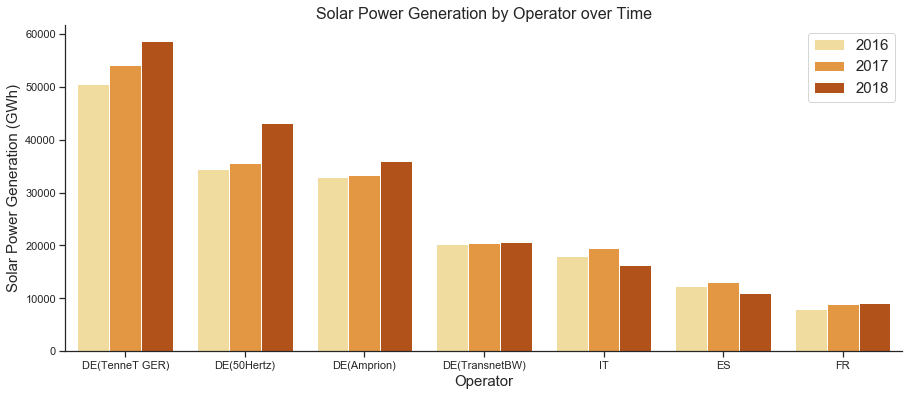

In [8]:
df = actuals.groupby(['operator','year'])['solar'].sum().sort_values(ascending=False).reset_index()
df['solar'] = df['solar']/1000

sns.barplot(x='operator', y='solar', hue='year', data=df, palette='YlOrBr')
plt.ticklabel_format(style='plain', axis='y')
plt.title('Solar Power Generation by Operator over Time')
plt.xlabel('Operator')
plt.ylabel('Solar Power Generation (GWh)')
plt.legend(loc='best', frameon=True, fancybox=True)
sns.despine()

### Installed Capacity by Operator over Time

Solar power capacity is increasing across the board, although gains have slowed in Spain and Italy. There seem to be data quality issues with French data

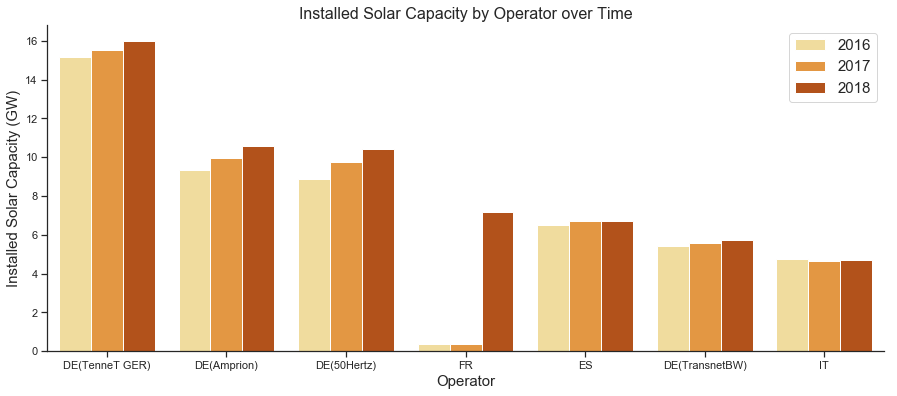

In [9]:
df = capacity.groupby(['operator','year'])['solcap'].sum().sort_values(ascending=False).reset_index()
df['solcap'] = df['solcap']/1000

sns.barplot(x='operator', y='solcap', hue='year', data=df, palette='YlOrBr')
plt.ticklabel_format(style='plain', axis='y')
plt.title('Installed Solar Capacity by Operator over Time')
plt.xlabel('Operator')
plt.ylabel('Installed Solar Capacity (GW)')
plt.legend(loc='best', frameon=True, fancybox=True)
sns.despine()

## Seasonality

### By Month

Generation across all operators fluctuates with the seasons, with summer numbers being several mulitples above those in winter.

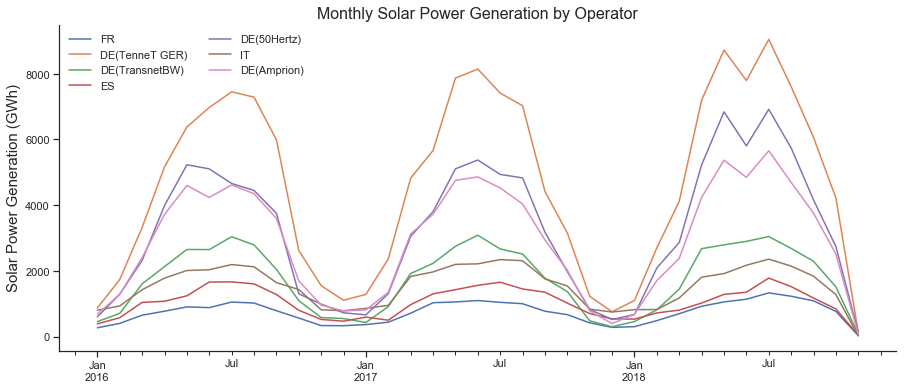

In [10]:
for o in actuals['operator'].unique():
    g = (actuals[actuals['operator'] == o].resample('M')['solar'].sum()/1000).plot(label=o)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Monthly Solar Power Generation by Operator')
plt.xlabel('')
plt.ylabel('Solar Power Generation (GWh)')
plt.legend(loc='best', ncol=2, frameon=False, fancybox=True, fontsize=11)
sns.despine()

While I was expecting seasonal effects, the extent to which generation is affected by the time of year is surprising. As data for the largest German operators in 2018 shows, this differential will only get worse as capacity and generation increase.

### By Time of Day

As expected, solar power production follows the course of the day. The non-linear relationship between capacity and generation given external conditions is starkly evident here as well

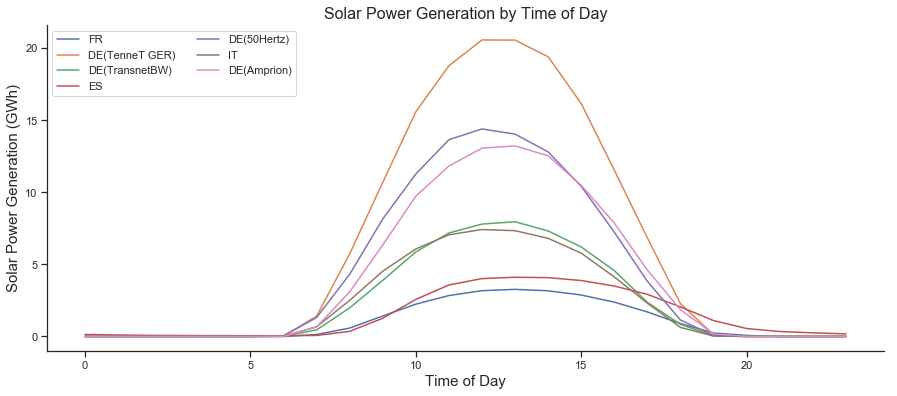

In [17]:
for o in actuals['operator'].unique():
    a_op = actuals[actuals['operator'] == o]
    ah = pd.DataFrame(a_op.resample('H')['solar'].sum()/1000)
    ah.groupby(ah.index.hour)['solar'].median().plot(label=o)

plt.ticklabel_format(style='plain', axis='y')
plt.title('Solar Power Generation by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Solar Power Generation (GWh)')
plt.legend(loc='upper left', ncol=2, frameon=True, fancybox=True, fontsize=11)
sns.despine()

## Volatility

While the seasonality curves above look nice and smooth, there's a lot of variation they don't explain. Generation peaks from one day to the next show just how much solar power production can vary due to fluctuating weather conditions. The figures below show daily generation data for TenneT and France in July 2018.

### Spread

In [13]:
a = actuals_hourly.groupby(['operator', 'base_hour'])['solar'].sum()/1000

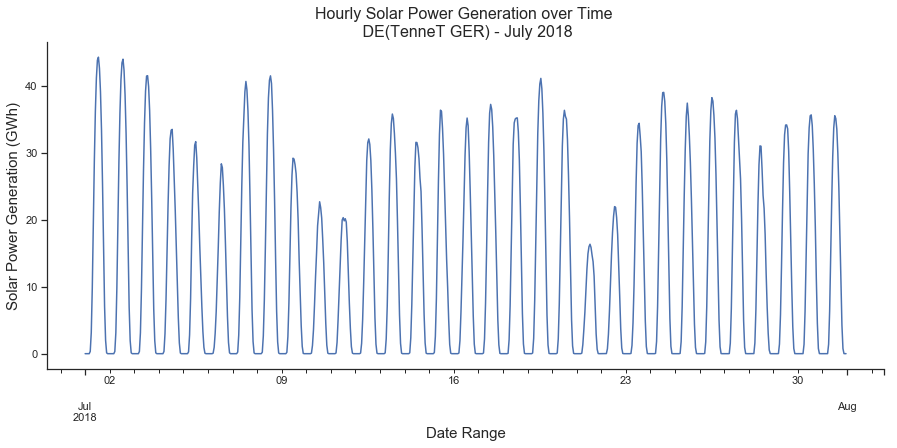

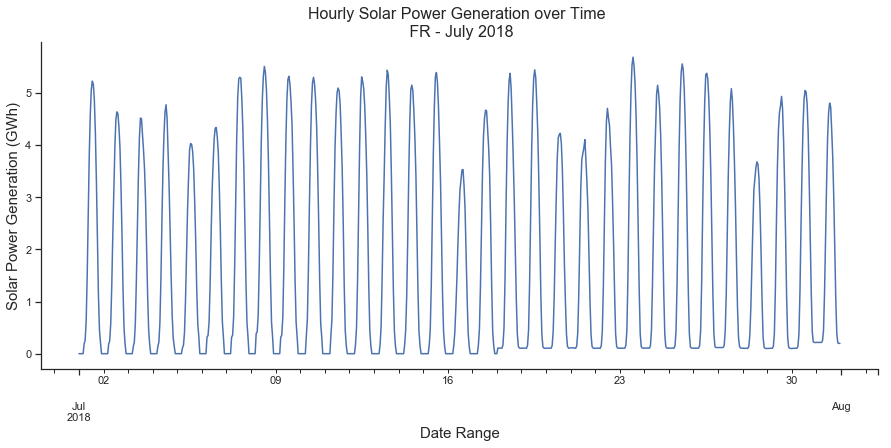

In [16]:
operators = ['DE(TenneT GER)', 'FR']
start = '2018-07-01'
end = '2018-07-31'

for o in operators:
    data = a.ix[o]
    data.index = pd.DatetimeIndex(data.index)
    data[start:end].plot(label=o)
    plt.ticklabel_format(style='plain', axis='y')
    plt.title('Hourly Solar Power Generation over Time \n {} - July 2018'.format(o))
    plt.xlabel('Date Range')
    plt.ylabel('Solar Power Generation (GWh)')
    sns.despine()
    plt.show()

Interestingly, in addition to the day to day variations, there seem to be trends lasting several days, likely due to the weather getting worse or clearing up over time. 

Investigating this daily variation more systematically, the boxplots below show the distriubution of generation by time of day, focusing on the largest operator (TenneT) for a single month (July 2018). The variation is significant, with a number of extreme outliers. The distribution is wider during late morning and early afternoon, suggesting that transitional periods will be harder to predict.

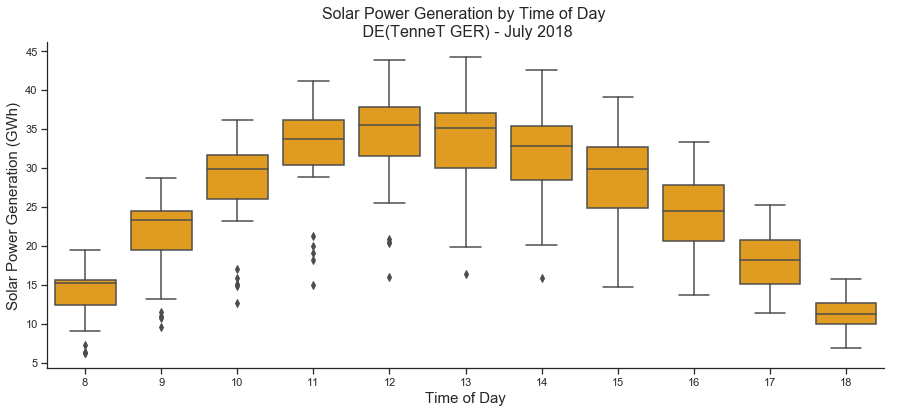

In [20]:
operator = 'DE(TenneT GER)'
start = '2018-07-01'
end = '2018-07-31'

data = a.ix[operator]
data.index = pd.DatetimeIndex(data.index)
data = pd.DataFrame(data)
data['hour'] = data.index.hour
data = data[(data['hour'] > 7) & (data['hour'] < 19)]

sns.boxplot(x="hour", y="solar", data=data[start:end], color='orange')
# sns.swarmplot(x="hour", y="solar", data=data[start:end], color='.5', alpha='.5')
plt.ticklabel_format(style='plain', axis='y')
plt.title('Solar Power Generation by Time of Day \n {} - July 2018'.format(operator))
plt.xlabel('Time of Day')
plt.ylabel('Solar Power Generation (GWh)')
sns.despine()

The violin plots below compare generation distributions across Summer and Spring/Fall. Data for Amprion and Italy in 2018 shows that distributions in transitional seasons are almost always flatter and wider, stemming from the weather being more variable.

In [21]:
# Assign seasons
summer = [5,6,7,8]
spring_fall = [3,4,9,10]
winter = [1,2,11,12]
a = a.reset_index()
a.index = pd.DatetimeIndex(a['base_hour'])
a['hour'] = a.index.hour
a['month'] = a.index.month
a.loc[a['month'].isin(summer), 'season'] = 'Summer'
a.loc[a['month'].isin(spring_fall), 'season'] = 'SpringFall'
a.loc[a['month'].isin(winter), 'season'] = 'Winter'

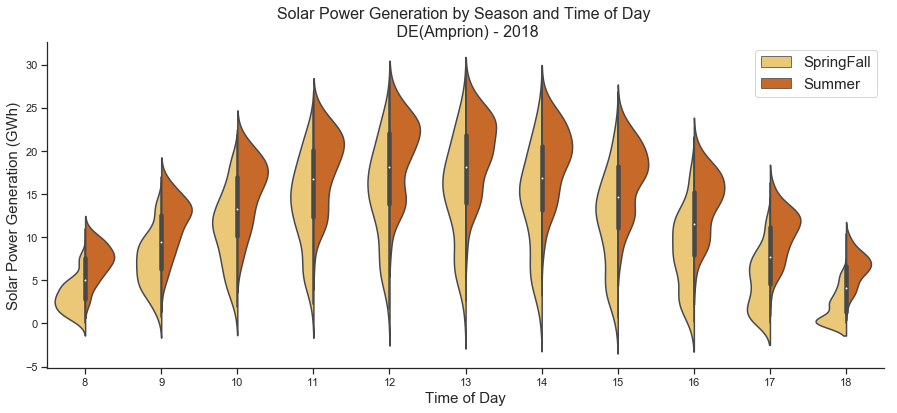

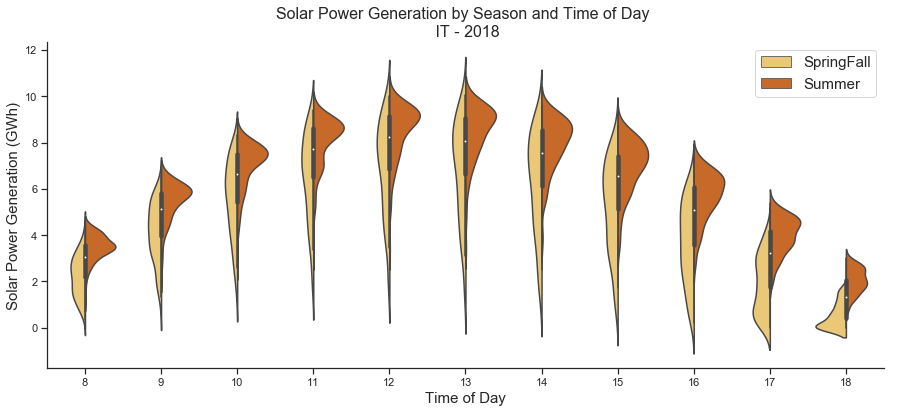

In [22]:
operators = ['DE(Amprion)', 'IT']
year = '2018'

data = a[year]
data = data[data['season'] != 'Winter']
data = data[(data['hour'] > 7) & (data['hour'] < 19)]

for o in operators:
    data_o = data[data['operator'] == o]
    sns.violinplot(x="hour", y="solar",  hue="season", data=data_o, split=True, palette='YlOrBr')
    plt.ticklabel_format(style='plain', axis='y')
    plt.title('Solar Power Generation by Season and Time of Day \n {} - 2018'.format(o))
    plt.xlabel('Time of Day')
    plt.ylabel('Solar Power Generation (GWh)')
    plt.legend(title=None,frameon=True, fancybox=True, fontsize=15)
    sns.despine()
    plt.show()

## Weather

Given how generation varies with weather, it's worth visually exploring the relationship between weather conditions - cloud cover, precipitation probability, visibility, and temperature - and solar power generation

Modelling will determine optimal weights for the 5 locations representing each operator. For the purposes of exploration however, we will weigh them equally and take the average.

In [23]:
def get_weather_means(weather, wcols):
    allcols = weather.columns
    remcols = 'apparent|time'
    cols_to_rmv = allcols.str.contains(r'{}'.format(remcols), case=False)
    cols = allcols[~cols_to_rmv]
    
    df = weather[['operator','localtime']]
    for i in wcols:
        colstoavg = cols[cols.str.contains(i, case=False)]
        #print(colstoavg)
        m = pd.DataFrame(weather[colstoavg].mean(axis=1))
        m.columns = [i]
        df = pd.concat([df, m], axis=1)
    return df


def setup_wdata(actuals, weather):
    wdata = actuals[['operator','base_hour','hour','solar']].merge(weather, left_on=['operator','base_hour'], right_on=['operator','localtime'])
    wdata.rename(columns={'solar': 'Solar'}, inplace=True)
    
    # Limit the data to daytime to make things cleaner
    wdata = wdata[(wdata['hour'] > 7) & (wdata['hour'] < 19)]
    wdata = wdata.set_index(pd.DatetimeIndex(wdata['localtime']))
    return wdata

In [24]:
whcols = ['CloudCover', 'Temperature', 'UVIndex']

avg_hweather = get_weather_means(weather_hourly, whcols)
wdata = setup_wdata(actuals_hourly, avg_hweather)

In [25]:
def plot_pairplot(wdata, operator, timeperiod):
    plot_kws={'line_kws':{'color':'orange'}, 'scatter_kws': {'alpha': 0.5, 's':20}}
    data = wdata[wdata['operator'] == operator]
    sns.pairplot(data[timeperiod], vars=['Solar']+whcols,  kind='reg', 
             plot_kws=plot_kws)
    plt.subplots_adjust(top=0.88)
    plt.suptitle('Solar Power Generation by Weather Conditions \n {} \n {}'.format(operator, timeperiod))
    plt.show()

Starting with Spain in August, there's a clear positive correlation between the UVIndex, the temperature, and solar power generation. Interestingly, generation initially rises exponentially with the temperature, but flattens and begin to decline above 25 Degrees. Higher temperatures are [known](https://www.1876energy.com/how-does-the-weather-affect-solar-panel-efficiency/) to reduce solar panel efficiency, but the abruptness of the curve suggests curtailment of excess generation. I was expecting cloud cover to have a negative impact, but that isn't visible here. It's likely more observable further North or during cooler parts of the year

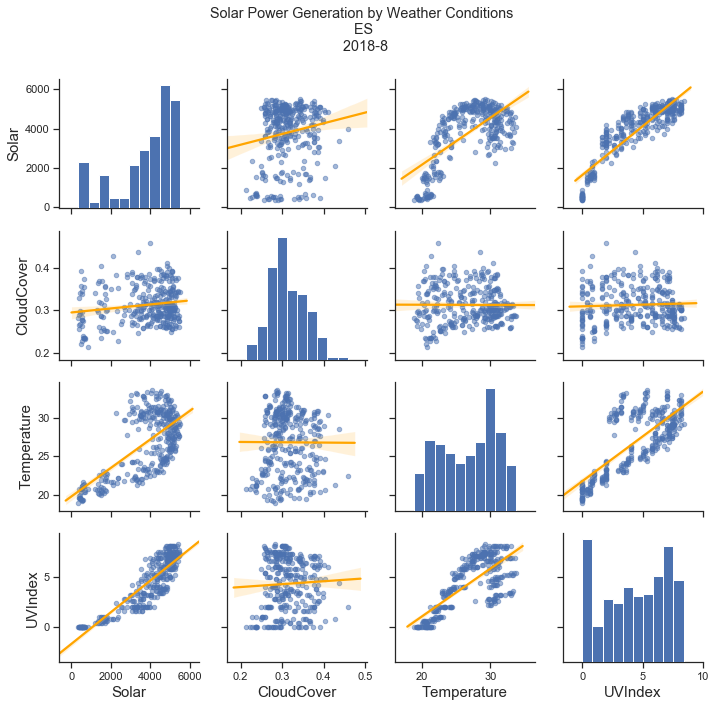

In [26]:
plot_pairplot(wdata, 'ES', '2018-8')

As expected, the German grid in August does show cloud cover having a negative effect on generation. Correspondingly, the effect of temperature is more muted, while the impact of the UVIndex is still strong

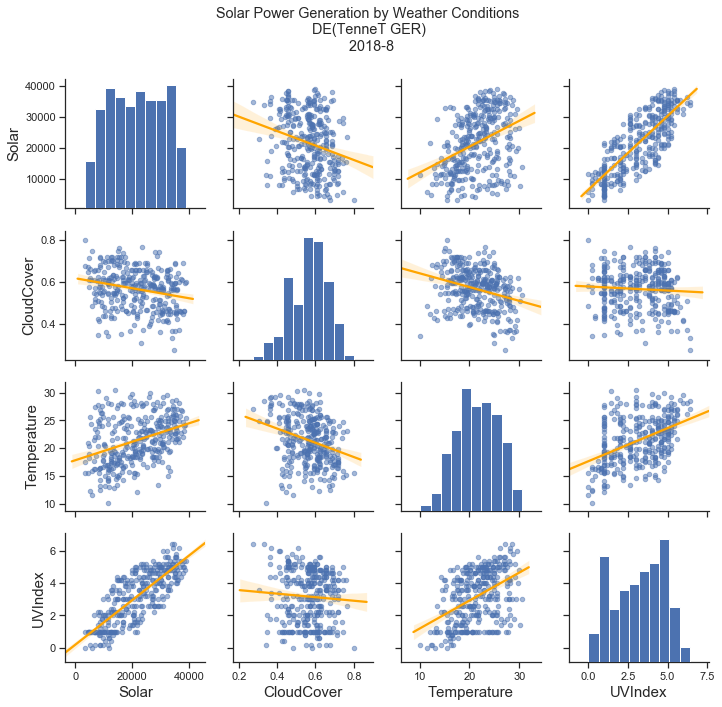

In [27]:
plot_pairplot(wdata, 'DE(TenneT GER)', '2018-8')

In March however, the impact of temperature becomes more muddled, while that of cloud cover and the UVIndex becomes stronger, as shown for Italy below

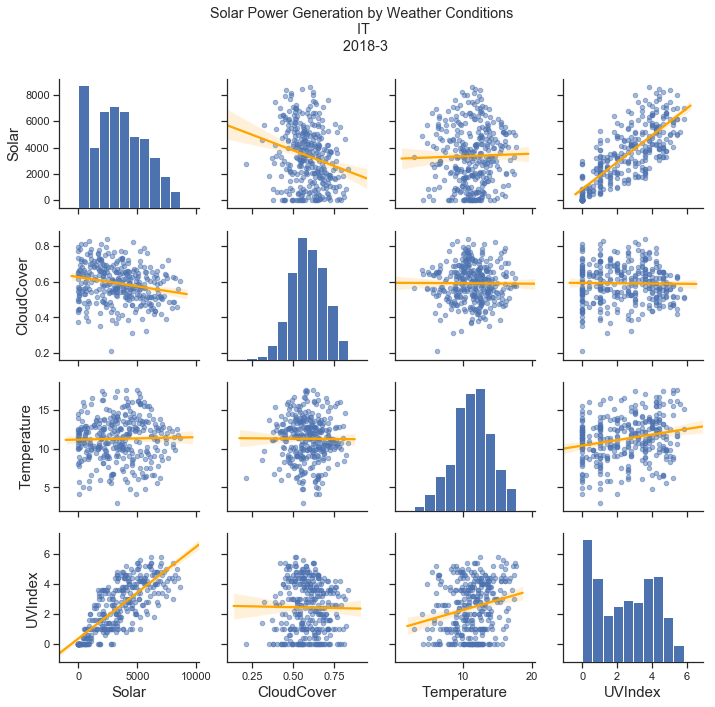

In [28]:
plot_pairplot(wdata, 'IT', '2018-3')

All of this shows the extent to which the model have will have to adjust given the time of year 

Out of curiosity, I wanted to visualize how much the weather differed across Germany and Spain. Looking at August 2018, as expected, the cloud cover is lower, and the temperature and UVIndex are consistently higher.

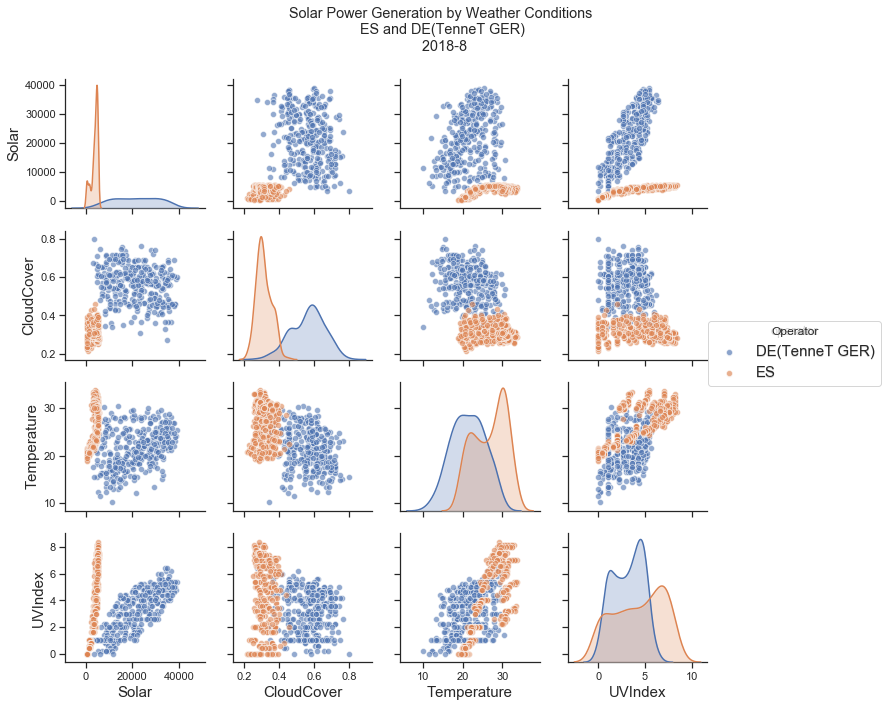

In [29]:
operators = ['ES','DE(TenneT GER)']
data = wdata[wdata['operator'].isin(operators)]
timeperiod = '2018-8'

g = sns.pairplot(data[timeperiod], hue='operator', vars=['Solar']+whcols, plot_kws = {'alpha': 0.6})

handles = g._legend_data.values()
labels = g._legend_data.keys()
g.fig.legend(title='Operator', handles=handles, labels=labels, loc='right', ncol=1)
plt.subplots_adjust(top=0.88)
plt.suptitle('Solar Power Generation by Weather Conditions \n {} and {} \n {}'.
              format(operators[0], operators[1], timeperiod))
plt.show()

## Weights

While we averaged weather across coordinates above, I was curious if some points were more important than others when it came to determining overall solar output. A comparison of the correlation between the weather at a specific point and total solar power production should give an indication of the relative importance of different coordinates. The UV Index has the clearest relationship with generation, but it's also likely to be very similar across all coordinates at any given point in time. We'll go with cloud cover instead. 

Interestingly, the plot below shows that some points are definitely more important than others - something the modeling should pick up on. This also points us in the right direction if we ever want to expand the number of coordinates we're working with. Points geographically closer to the ones that are highly correlated with total output will improve model performance more than points further away.

In [30]:
allcols = weather_hourly.columns
wuv = weather_hourly[['operator','localtime']]
uvcols = allcols[allcols.str.contains('cloudcover', case=False)]
wuvact = pd.concat([wuv, pd.DataFrame(weather_hourly[uvcols])], axis=1)

wdata = setup_wdata(actuals_hourly, wuvact)

corr_list = []
for o in actuals_hourly['operator'].unique():
    df = wdata[wdata['operator']==o]
    corrs = pd.DataFrame(df[list(uvcols)+['Solar']].corr()['Solar'][:-1]).transpose()
    corrs['operator'] = o
    corr_list.append(corrs)
correlations = pd.concat(corr_list)
correlations = correlations.set_index('operator')
correlations = correlations.rename(columns={col: col.split('_')[0] for col in correlations.columns})

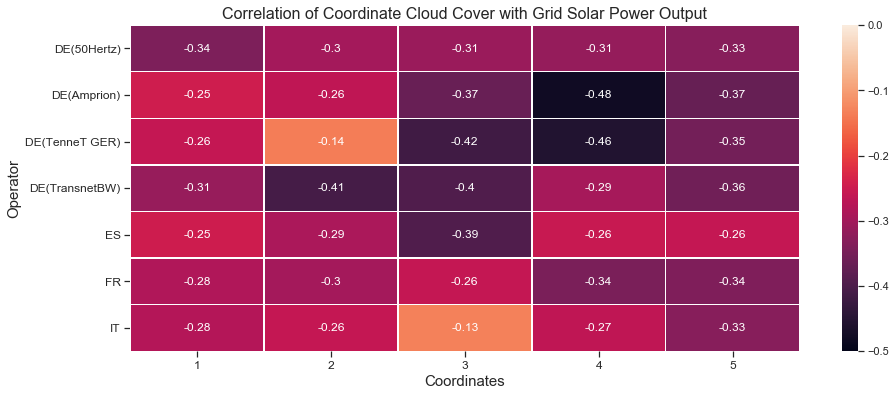

In [31]:
sns.heatmap(correlations, annot=True, vmin=-0.5, vmax=0, linewidths=.5)
plt.title('Correlation of Coordinate Cloud Cover with Grid Solar Power Output', y=1.02)
plt.xlabel('Coordinates', fontsize=15)
plt.ylabel('Operator', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=12)

## Key Takeaways

- There are clear trends and seasonal patterns in the data
- Given how much variability is observed over relatively short periods of time, features representing generation over the past few hours or days will help algorithms levelset
- There are strong multi-day trends in generation, quantifying these movements across days will be useful
- Rates of change within a day should also help with current forecasts
- As expected, some aspects of the weather (Cloud Cover, Temperature, UVIndex) are more important than others
- While some coordinates are more closely correlated with total production than others, all of them seem to have something to contribute
- Models will have to be able to levelset, infer generation from the weather, capture seasonality, weigh different coordinates, and extrapolate from trends